# Machine Translation (Sequence-to-Sequence)

- Character-based machine translation using seq-to-seq model
- This is based on:
    - [A ten-minute introduction to sequence-to-sequence learning in Keras](https://keras.io/examples/nlp/lstm_seq2seq/)
    - [Day 18:機器翻譯(Machine Translation](https://ithelp.ithome.com.tw/articles/10194403)
- Data: 
    - [English to French sentence pairs](http://www.manythings.org/anki/fra-eng.zip)
    - [Paired Datasets of Other languages](http://www.manythings.org/anki/)
- References
    - [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
    - [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [2]:
# Path to the data txt file on disk.
data_path = '../../../RepositoryData/data/cmn.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# Sort Dictionary
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

# Find maxinum sent lengths 
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 73
Number of unique output tokens: 2640
Max sequence length for inputs: 31
Max sequence length for outputs: 22


In [3]:
# Create char index dictionary
## char as the key and index as the value
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])


# Initialize encoder/decoder


## Both input output are three dimensional tensors,
## consisting of each sentence, with all words encoded in one-hot.

## Input tensor dimensions: [input_batch_size, input_sequence_length, input_vecob/char_size]
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

## Output tensor dimensions: [output_batch_size, output_sequence_length, output_vecob/char_size]
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [4]:
# One-hot encode input and output texts
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [5]:
## Define Model


## Set up encoder
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens)) # one word at a time, with vocab_size dimension, i.e., one-hot encoding
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)


# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c] # concatenate the states_h and states_c from encoder ?

## the encoder_states shape: [state_h + state+c, latent_dim]

In [6]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens)) # one word at a time, with vocab_size dimension,

# We set up our decoder to return full output sequences, (i.e, `return_sequences=True`)
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

## softmax the decoder outputs to get prob of target language word
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [7]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

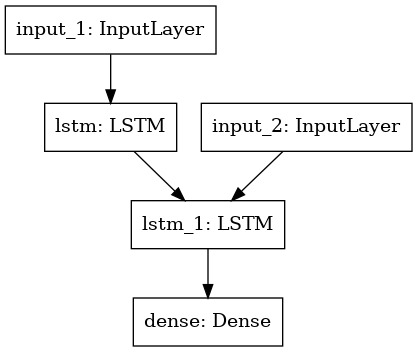

In [9]:
from keras.utils import plot_model
import pydot
plot_model(model)

In [ ]:
# # Run training
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_split=0.2)

In [ ]:
# Save model
# model.save('../data/s2s-cmn.h5')


In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 2640)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 337920      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  2966528     input_2[0][0]                    
                                                                 lstm[0][1]            

In [11]:
## If the model is loaded via external files
## Load the encoder_model, decoder_model this way
from keras.models import load_model
model.load_weights('../../../RepositoryData/data/s2s-cmn.h5')



## Create Inference model
encoder_inputs = model.input[0] #input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)


decoder_inputs = model.input[1] #input_2
decoder_state_input_h = Input(shape=(latent_dim,),name='input_3') # state_h
decoder_state_input_c = Input(shape=(latent_dim,),name='input_4') # state_c
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c] # concat state_h and state_c

decoder_lstm = model.layers[3]

## In training, we use `decoder_ouputs` only.
## In inferencing, we need `decoder_c, and decoder_h`
## because these c and h form the basis for next decoder input
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs=decoder_dense(decoder_outputs)


## Inference Model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, # target sentence + encoder output h+c
    [decoder_outputs] + decoder_states) # decoder predicted char + decoder predicted h+c

In [12]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        # inference starts at the first target char
        # first target char + encoder output h + c
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        ## Choose the output char of the argmax prob
        ## one-hot decode the char and append to the `decoded_sentence`
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        ## everytime the target_seq is the cur_t char, one char a time
        ## the shape should be [1, ,1 vocab_size]
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        ## the h and c output from decoder at cur_t
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Hi.
Decoded sentence: 你好。

-
Input sentence: Hi.
Decoded sentence: 你好。

-
Input sentence: Run.
Decoded sentence: 你用跑的。

-
Input sentence: Wait!
Decoded sentence: 等等！

-
Input sentence: Hello!
Decoded sentence: 你好。

-
Input sentence: I try.
Decoded sentence: 让我来。

-
Input sentence: I won!
Decoded sentence: 我赢了。

-
Input sentence: Oh no!
Decoded sentence: 不会吧。

-
Input sentence: Cheers!
Decoded sentence: 乾杯!

-
Input sentence: He ran.
Decoded sentence: 他跑了。

